In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)
from tqdm import tqdm
from collections import OrderedDict

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display

# Utilities
from aif360.utils.general_utils import compute_metrics
from aif360.utils.classifier_metrics import ClassifierMetricUtils

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas


import matplotlib.pyplot as plt

# Explainers
from aif360.explainers import MetricTextExplainer

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [17]:
dataset_orig = CompasDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['Female']],
    features_to_drop=['race', 'age']
)

dataset_orig_train, dataset_orig_val, dataset_orig_test = dataset_orig.split([0.7,0.8], shuffle=True)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [18]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [19]:
dataset_orig_valid_pred = dataset_orig_val.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [20]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_val,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
#     print(classified_metric_orig_valid.binary_confusion_matrix())
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6684
Optimal classification threshold (no reweighing) = 0.5445


In [21]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

 47%|████▋     | 47/100 [00:00<00:00, 468.61it/s]

Classification threshold used = 0.5445
Balanced accuracy = 0.6508
Statistical parity difference = -0.3405
Disparate impact = 0.5918
Average odds difference = -0.3115
Equal opportunity difference = -0.2625
Theil index = 0.2297


100%|██████████| 100/100 [00:00<00:00, 370.82it/s]


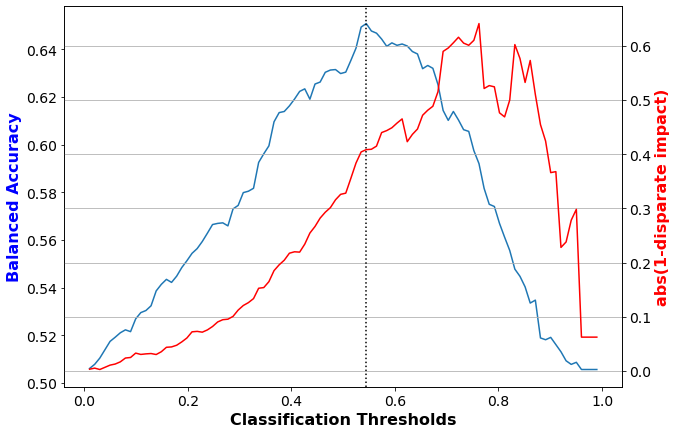

In [22]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [23]:
# Compute metrics for best thresh
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

classifier_metrics = ClassifierMetricUtils(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups)

classifier_metrics.compute_metrics()

Balanced accuracy = 0.6508
Statistical parity difference = -0.3405
Disparate impact = 0.5918
Average odds difference = -0.3115
Equal opportunity difference = -0.2625
Theil index = 0.2297


In [24]:
classifier_metric = classifier_metrics.compute_metrics()
original_metrics = classifier_metrics.get_metrics()
classifier_metrics.explain_metrics()

Balanced accuracy = 0.6508
Statistical parity difference = -0.3405
Disparate impact = 0.5918
Average odds difference = -0.3115
Equal opportunity difference = -0.2625
Theil index = 0.2297
Classification accuracy (ACC): 0.6539708265802269
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.34050999543142024
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5917541452623295
Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.3115260430673924
True positive rate difference (true positive rate on unprivileged instances - true positive rate on privileged instances): -0.26246187822063316
Theil index (generalized entropy index with alpha = 1): 0.22967637793711856


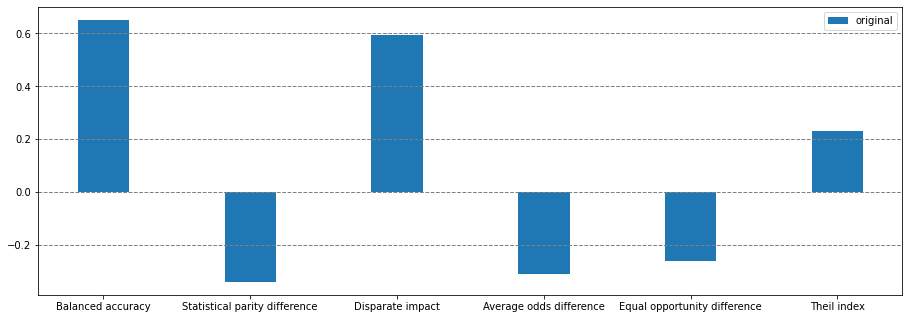

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,-1,2,1])
x_ticks = list(original_metrics.keys())
original_values = list(original_metrics.values())
ax.bar(x_ticks,original_values, width= 0.35)
ax.legend(labels=['original'])
plt.grid(True, 'major', 'y', color='gray', linestyle='--', linewidth=1)
plt.show()


In [26]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [27]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

In [13]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [14]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [15]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

100%|██████████| 100/100 [00:00<00:00, 556.72it/s]

Classification threshold used = 0.6138
Balanced accuracy = 0.6205
Statistical parity difference = 0.0046
Disparate impact = 1.0109
Average odds difference = 0.0208
Equal opportunity difference = 0.0008
Theil index = 0.3496


Balanced accuracy = 0.6205
Statistical parity difference = 0.0046
Disparate impact = 1.0109
Average odds difference = 0.0208
Equal opportunity difference = 0.0008
Theil index = 0.3496


ValueError: shape mismatch: objects cannot be broadcast to a single shape

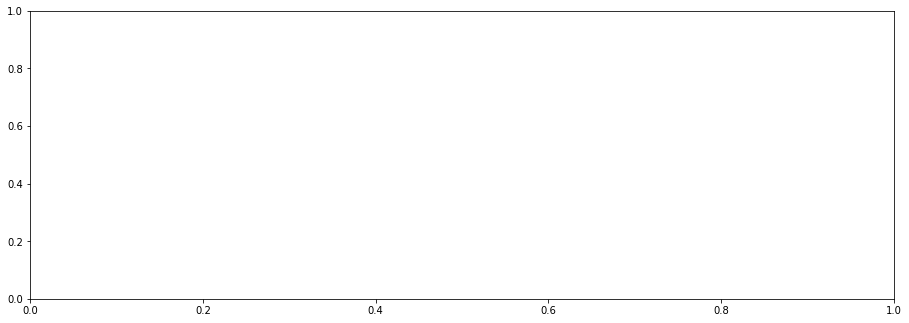

In [16]:
# Compute metrics for best thresh
fav_inds = dataset_transf_test_pred.scores > best_class_thresh
dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

classifier_metrics_trans = ClassifierMetricUtils(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups)
classifier_metrics_trans.compute_metrics()
transformed_metrics = classifier_metrics_trans.get_metrics()
fig = plt.figure()
ax = fig.add_axes([0,-1,2,1])
transformed_values = list(transformed_metrics.values())
X = np.arange(5)
ax.bar(X + 0.00, original_values, width=0.35)

for index, value in enumerate(original_values):
    plt.text(index, value, str(round(value, 2)))
    
ax.bar(X + 0.35, transformed_values, width=0.35)

for index, value in enumerate(transformed_values):
    plt.text(index + 0.25, value, str(round(value, 2)))

ax.set_xticks(X)
ax.set_xticklabels(x_ticks)
ax.legend(labels=['original', 'mitigated'])
plt.grid(True, 'major', 'y', color='gray', linestyle='--', linewidth=1)
plt.show()